In [1]:
# import the package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import re
import seaborn as sns
# import packages
from sklearn.linear_model import LogisticRegression
from spellchecker import SpellChecker
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
import en_core_web_lg
import spacy 
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
from tracemalloc import stop
from langcodes import best_match
from matplotlib import rc
import tomotopy as tp
from gensim.models import Phrases
nlp = spacy.load("en_core_web_lg")
import pickle # for spelling chcker
# import glob, os
# from rich.console import Console
# from rich.table import Table
# ! pip install pyLDAvis
# ! python -m spacy download en_core_web_lg
# ! pip install pyspellchecker
# ! pip install tomotopy

from rich.console import Console
from rich.table import Table


# load the data
df_train = pd.read_csv('./NLP_dataset/train.csv')
df_test = pd.read_csv('./NLP_dataset/test.csv')
df_submission = pd.read_csv('./NLP_dataset/submission_file.csv')

/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/gensim/matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, defaultdict
/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/gensim/models/doc2vec.py:73: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import namedtuple, defaultdict, Iterable


In [2]:
df_train

helpfulness_cat                                   imdb_user_review
0                  1.0  It is hard to find such delightful and adorabl...
1                  1.0  They don't make films like this faded, hauntin...
2                  1.0  I first viewed this movie in 1924 at age 6 yrs...
3                  1.0  I doubt that I'd ever seen anything resembling...
4                  1.0  I was shocked to find myself riveted to this m...
...                ...                                                ...
10750              0.0  The makers of this movie really touched a sore...
10751              0.0  I Care A Lot is an exhilarating black comedy w...
10752              0.0  Really loved this. This film is masterful in t...
10753              0.0  The story, direction and acting across the boa...
10754              0.0  This movie ruled! It had such a unique premise...

[10755 rows x 2 columns]

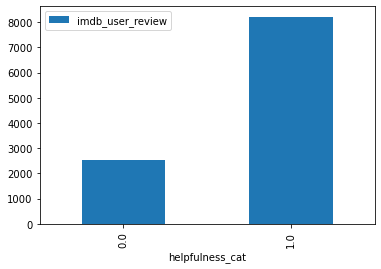

In [3]:
# check the distribution of the dataset by category
df_train.groupby('helpfulness_cat').count().plot.bar(ylim=0)
plt.show()

In [4]:
df_test

_id  \
0     610d01fe9a63eb113d2235ac   
1     610d01fe9a63eb113d224536   
2     610d01fe9a63eb113d224d14   
3     610d01fe9a63eb113d225f17   
4     610d01fe9a63eb113d225f1a   
...                        ...   
5066  610d02269a63eb113d5ecec2   
5067  610d02269a63eb113d5ecec4   
5068  610d02269a63eb113d5ececb   
5069  610d02269a63eb113d5ed17e   
5070  610d02269a63eb113d5ed242   

                                       imdb_user_review  
0     This is basically a German takeoff on a Sherlo...  
1     In January of 1924, director Erich von Strohei...  
2     Silent movies are not for everyone. Neither ar...  
3     It so often happens that some films take the l...  
4     I saw this film for the very first time last w...  
...                                                 ...  
5066  Had to fast forward a few parts of the movie j...  
5067  This is movie is total garbage. If I could rat...  
5068  Paints court appointed guardians as completely...  
5069  Everyone knows how incredible and talented Ros...  
5070  Terrific performances across the board. Genius...  

[5071 rows x 2 columns]

### Preprocessing text
- use any classifier or combination of classifiers, any combination or selection of features, and either supervised, semi-supervised, or even transfer learning approaches
- BoW vectors, TFIDF vectors, vectors achieved with embedding algorithms, topic-to-document probabilities. 
- In terms of estimators, you can use logistic regression, Naive Bayes Classifier, or any other estimator you think is appropriate given the nature of the task

In [5]:
# # define a data cleaning function
# def clean_data(reviews):
#     # # step 1: separate x and y
#     # convert review_text df to list
#     reviews_backup = reviews.copy()
#     reviews = reviews.to_list()
    
#     # step 2: nromalize the review
#     print(f"Total voc number: {len(reviews)}")
#     reviews = list(map(lambda x: x.lower(),reviews))

#     # step 3: remove Unicode Characters (punctuation, emoji,rul and @) 
#     reviews = list(map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x),reviews))

#     # step 4: remove whitespaces and trailing spaces
#     def remove_whitespace(text):
#         pattern = re.compile(r'\s+') 
#         Without_whitespace = re.sub(pattern, ' ', text)
#         text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
#         text = text.strip()
#         return text
#     reviews=list(map(lambda x: remove_whitespace(x),reviews))
                                                                                                                                                                                                                                                                                                    
#     # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    
#     # expand the list of stopwords
#     gist_file = open("./NLP_dataset/gist_stopwords.txt", "r")
#     try:
#         content = gist_file.read()
#         stopwords = content.split(",")
#     finally:
#         gist_file.close()
      
#     stopwords=[i.replace('"',"").strip() for i in stopwords]
#     # add the stopwords to the list of stopwords
#     for i in stopwords:
#       nlp.Defaults.stop_words.add(i)

#     # create colloum for cleaned reviews
#     reviews_tokens, tmp_tokens = [], [] 
#     for review in tqdm.tqdm(reviews):
#         tmp_tokens = [
#             token.lemma_
#             for token in nlp(review)
#             if not token.is_stop 
#             and not token.like_num
#             and not token.is_punct
#             and token.is_alpha
#             ]
#         reviews_tokens.append(tmp_tokens)
#         tmp_tokens=[]

#     # # build spell checker and create spell mistakes
#     # spell = SpellChecker()
#     # mdy_train, temp_train = [], []
#     # for comment in tqdm.tqdm(reviews_tokens):
#     #     temp_train = [word if word in spell else spell.correction(word) for word in comment]
#     #     mdy_train.append(temp_train)
#     #     temp_train=[]

#     # seperate the text to noun, adj, verb, adv
#     def tag_reviews(reviews):
#         tags = ['NOUN','ADJ','VERB','ADV']
#         reviews_tokens, tmp_tokens = [], [] 
#         for review in tqdm.tqdm(reviews):
#             tmp_tokens = [
#                 token.lemma_
#                 for token in nlp(review)
#                 if not token.is_stop 
#                 and not token.like_num
#                 and not token.is_punct
#                 and token.is_alpha
#                 and token.pos_ in tags 
#                 ]
#             reviews_tokens.append(tmp_tokens)
#             tmp_tokens=[]
#         return reviews_tokens

#     # use apply lambda to apply the function to the list of reviews
#     # df_train_clean['imdb_user_review'] =df_train_clean['imdb_user_review'].apply(tag_reviews)
#     df_train_clean['imdb_user_review'] =tag_reviews(reviews)
#     # reviews_tokens = tag_reviews(df_train_clean['imdb_user_review'])

#     # convert list back to df 
#     reviews = pd.DataFrame({'imbd_user_review':reviews_tokens})

#     return reviews_tokens

In [6]:
# define a data cleaning function
def clean_data(reviews):
    # # step 1: separate x and y
    # convert review_text df to list
    reviews = reviews.to_list()
    
    # step 2: nromalize the review
    print(f"Total voc number: {len(reviews)}")
    reviews = list(map(lambda x: x.lower(),reviews))

    # step 3: remove Unicode Characters (punctuation, emoji,rul and @) 
    reviews = list(map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x),reviews))

    # step 4: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    reviews=list(map(lambda x: remove_whitespace(x),reviews))
                                                                                                                                                                                                                                                                                                    
    # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    
    # expand the list of stopwords
    gist_file = open("./NLP_dataset/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
      
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
      nlp.Defaults.stop_words.add(i)

    review  = pd.DataFrame({'imbd_user_review':reviews})

    def tokenized_reviews(text):
        return [str(token) for token in nlp(text) 
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]

    def tag_reviews(text):
        tags = ['NOUN','ADJ','VERB','ADV']
        return [token.pos_ for token in nlp(text) 
                if not token.is_stop 
                and not token.like_num
                and not token.is_punct
                and token.is_alpha
                # and token.pos_ in tags 
                ]

    review['tokens'] = review['imbd_user_review'].apply(tokenized_reviews)
    review['tags'] = review['imbd_user_review'].apply(tag_reviews)

    return review

In [7]:
# separate x and y
review_text = df_train['imdb_user_review']
review_cat = df_train['helpfulness_cat']
train = clean_data(review_text)

# concat the helpfulness_cat to the train
train['helpfulness_cat'] = review_cat
train

Total voc number: 10755


imbd_user_review  \
0      it is hard to find such delightful and adorabl...   
1      they dont make films like this faded haunting ...   
2      i first viewed this movie in 1924 at age 6 yrs...   
3      i doubt that id ever seen anything resembling ...   
4      i was shocked to find myself riveted to this m...   
...                                                  ...   
10750  the makers of this movie really touched a sore...   
10751  i care a lot is an exhilarating black comedy w...   
10752  really loved this this film is masterful in th...   
10753  the story direction and acting across the boar...   
10754  this movie ruled it had such a unique premise ...   

                                                  tokens  \
0      [hard, delightful, adorable, movies, days, kid...   
1      [nt, films, faded, haunting, masterpiece, sile...   
2      [viewed, movie, age, yrsprobably, movie, thoug...   
3      [doubt, d, resembling, complete, version, metr...   
4      [shocked, riveted, movie, doubt, scifi, movie,...   
...                                                  ...   
10750  [makers, movie, touched, sore, spot, grumpy, m...   
10751  [care, lot, exhilarating, black, comedy, headt...   
10752  [loved, film, masterful, feel, characters, mes...   
10753  [story, direction, acting, board, superb, pete...   
10754  [movie, ruled, unique, premise, acting, awesom...   

                                                    tags  helpfulness_cat  
0      [ADJ, ADJ, ADJ, NOUN, NOUN, NOUN, ADJ, NOUN, A...              1.0  
1      [PART, NOUN, VERB, VERB, NOUN, ADJ, NOUN, PROP...              1.0  
2      [VERB, NOUN, NOUN, NOUN, NOUN, VERB, ADJ, VERB...              1.0  
3      [VERB, AUX, VERB, ADJ, NOUN, NOUN, NOUN, ADJ, ...              1.0  
4      [ADJ, VERB, NOUN, NOUN, NOUN, NOUN, AUX, VERB,...              1.0  
...                                                  ...              ...  
10750  [NOUN, NOUN, VERB, ADJ, NOUN, ADJ, ADJ, NOUN, ...              0.0  
10751  [VERB, NOUN, ADJ, ADJ, NOUN, NOUN, NOUN, PROPN...              0.0  
10752  [VERB, NOUN, ADJ, VERB, NOUN, NOUN, ADJ, NOUN,...              0.0  
10753  [NOUN, NOUN, VERB, NOUN, ADJ, PROPN, PROPN, AD...              0.0  
10754  [NOUN, VERB, ADJ, NOUN, NOUN, ADJ, NOUN, ADV, ...              0.0  

[10755 rows x 4 columns]

In [8]:
# save the cleaned data
train.to_csv('./NLP_dataset/df_train_clean.csv', index=False)

In [9]:
# load the data 
df_train_clean = pd.read_csv('./NLP_dataset/df_train_clean.csv')

def remove_brackets(text):
    text = text.replace('[','')
    text = text.replace(']','')
    text = text.replace("'","")
    text = text.split(', ')
    return text

# use apply lambda to apply the function to df_train_clean['tokens']
temp_token = df_train_clean['tokens'].apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
docs_tokens

[['hard',
  'delightful',
  'adorable',
  'movies',
  'days',
  'kid',
  'silent',
  'movie',
  'rich',
  'winning',
  'beautiful',
  't',
  'nead',
  'chaplin',
  'coogan',
  'charming',
  'pair',
  'life',
  'film',
  'succees',
  'nicely',
  'light',
  'joy',
  'overwhelmingly',
  'sad',
  'sentimental',
  'eyes',
  'tears',
  'saddness',
  'happiness',
  'movies',
  'musicits',
  'simply',
  'oscarlevel',
  'movie',
  'sympathetic',
  'feeling',
  'touchingly',
  'funny',
  'moments',
  'masterpiece',
  'showing',
  'extraordinary',
  'talented',
  'person',
  'charlie',
  'chaplin',
  'film',
  'years',
  't',
  'age',
  't'],
 ['nt',
  'films',
  'faded',
  'haunting',
  'masterpiece',
  'silent',
  'cinema',
  'anymorewhen',
  'dracula',
  'sale',
  'movie',
  'rights',
  'men',
  'grab',
  'fwmurnau',
  'famous',
  'german',
  'directors',
  'time',
  'time',
  'word',
  'got',
  'rights',
  'storyline',
  'dracula',
  'owned',
  'rights',
  'florences',
  'widow',
  'murnau',


### Feature Engineering

Word Frequency

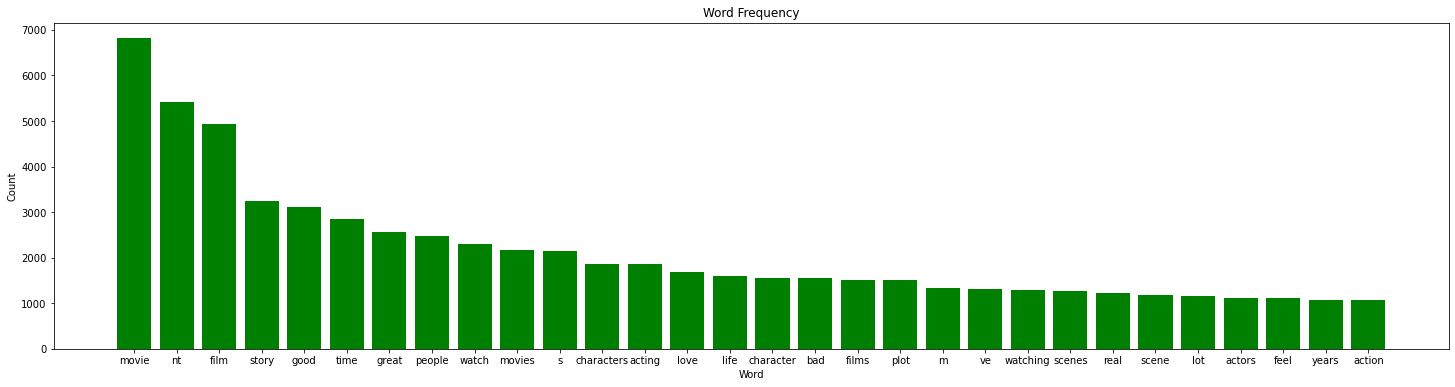

word  freq
0         movie  6817
1            nt  5424
2          film  4929
3         story  3247
4          good  3114
...         ...   ...
39004  thievery     1
39005    gothel     1
39006    gretel     1
39007   snuggly     1
64342  belforte     1

[64343 rows x 2 columns]

In [10]:
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(25, 6))
plt.bar(word_fr.word[0:30], word_fr.freq[0:30], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()
word_fr

In [11]:
train

imbd_user_review  \
0      it is hard to find such delightful and adorabl...   
1      they dont make films like this faded haunting ...   
2      i first viewed this movie in 1924 at age 6 yrs...   
3      i doubt that id ever seen anything resembling ...   
4      i was shocked to find myself riveted to this m...   
...                                                  ...   
10750  the makers of this movie really touched a sore...   
10751  i care a lot is an exhilarating black comedy w...   
10752  really loved this this film is masterful in th...   
10753  the story direction and acting across the boar...   
10754  this movie ruled it had such a unique premise ...   

                                                  tokens  \
0      [hard, delightful, adorable, movies, days, kid...   
1      [nt, films, faded, haunting, masterpiece, sile...   
2      [viewed, movie, age, yrsprobably, movie, thoug...   
3      [doubt, d, resembling, complete, version, metr...   
4      [shocked, riveted, movie, doubt, scifi, movie,...   
...                                                  ...   
10750  [makers, movie, touched, sore, spot, grumpy, m...   
10751  [care, lot, exhilarating, black, comedy, headt...   
10752  [loved, film, masterful, feel, characters, mes...   
10753  [story, direction, acting, board, superb, pete...   
10754  [movie, ruled, unique, premise, acting, awesom...   

                                                    tags  helpfulness_cat  
0      [ADJ, ADJ, ADJ, NOUN, NOUN, NOUN, ADJ, NOUN, A...              1.0  
1      [PART, NOUN, VERB, VERB, NOUN, ADJ, NOUN, PROP...              1.0  
2      [VERB, NOUN, NOUN, NOUN, NOUN, VERB, ADJ, VERB...              1.0  
3      [VERB, AUX, VERB, ADJ, NOUN, NOUN, NOUN, ADJ, ...              1.0  
4      [ADJ, VERB, NOUN, NOUN, NOUN, NOUN, AUX, VERB,...              1.0  
...                                                  ...              ...  
10750  [NOUN, NOUN, VERB, ADJ, NOUN, ADJ, ADJ, NOUN, ...              0.0  
10751  [VERB, NOUN, ADJ, ADJ, NOUN, NOUN, NOUN, PROPN...              0.0  
10752  [VERB, NOUN, ADJ, VERB, NOUN, NOUN, ADJ, NOUN,...              0.0  
10753  [NOUN, NOUN, VERB, NOUN, ADJ, PROPN, PROPN, AD...              0.0  
10754  [NOUN, VERB, ADJ, NOUN, NOUN, ADJ, NOUN, ADV, ...              0.0  

[10755 rows x 4 columns]

In [12]:
# remove most frequent words which is known in this context
word_list = word_fr.head(10)['word'].to_list()
mdy_train, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_train.append(tmp)
    tmp=[]

df_train_clean['tokens'] = mdy_train
df_train_clean


imbd_user_review  \
0      it is hard to find such delightful and adorabl...   
1      they dont make films like this faded haunting ...   
2      i first viewed this movie in 1924 at age 6 yrs...   
3      i doubt that id ever seen anything resembling ...   
4      i was shocked to find myself riveted to this m...   
...                                                  ...   
10750  the makers of this movie really touched a sore...   
10751  i care a lot is an exhilarating black comedy w...   
10752  really loved this this film is masterful in th...   
10753  the story direction and acting across the boar...   
10754  this movie ruled it had such a unique premise ...   

                                                  tokens  \
0      [hard, delightful, adorable, days, kid, silent...   
1      [films, faded, haunting, masterpiece, silent, ...   
2      [viewed, age, yrsprobably, thought, terrific, ...   
3      [doubt, d, resembling, complete, version, metr...   
4      [shocked, riveted, doubt, scifi, ve, let, expl...   
...                                                  ...   
10750  [makers, touched, sore, spot, grumpy, mans, mi...   
10751  [care, lot, exhilarating, black, comedy, headt...   
10752  [loved, masterful, feel, characters, message, ...   
10753  [direction, acting, board, superb, peter, dink...   
10754  [ruled, unique, premise, acting, awesome, rose...   

                                                    tags  helpfulness_cat  
0      ['ADJ', 'ADJ', 'ADJ', 'NOUN', 'NOUN', 'NOUN', ...              1.0  
1      ['PART', 'NOUN', 'VERB', 'VERB', 'NOUN', 'ADJ'...              1.0  
2      ['VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'VERB...              1.0  
3      ['VERB', 'AUX', 'VERB', 'ADJ', 'NOUN', 'NOUN',...              1.0  
4      ['ADJ', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN'...              1.0  
...                                                  ...              ...  
10750  ['NOUN', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'ADJ',...              0.0  
10751  ['VERB', 'NOUN', 'ADJ', 'ADJ', 'NOUN', 'NOUN',...              0.0  
10752  ['VERB', 'NOUN', 'ADJ', 'VERB', 'NOUN', 'NOUN'...              0.0  
10753  ['NOUN', 'NOUN', 'VERB', 'NOUN', 'ADJ', 'PROPN...              0.0  
10754  ['NOUN', 'VERB', 'ADJ', 'NOUN', 'NOUN', 'ADJ',...              0.0  

[10755 rows x 4 columns]

topic modelling

In [13]:
# # 使用“短語”方法，我們訓練一個捕獲二元組的模型（參見步驟 1）和一個捕獲三元組的模型（參見步驟 2）。
# common_terms = [
# u"of",u"with",u"without",u"and",u"or",u"the",
# u"a",u"not",u"be",u"to",u"this",u"who",u"in",
# ]

bigram = Phrases(                              # step 1 
    docs_tokens,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    # common_terms=common_terms,
)
trigram = Phrases(                             # step 2
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    # common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
# 借助這兩個模型，我們可以處理標記化的文檔並加入與二元組或三元組相關的標記。
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
docs_phrased

[['hard',
  'delightful',
  'adorable',
  'movies',
  'days',
  'kid',
  'silent',
  'movie',
  'rich',
  'winning',
  'beautiful',
  't',
  'nead',
  'chaplin',
  'coogan',
  'charming',
  'pair',
  'life',
  'film',
  'succees',
  'nicely',
  'light',
  'joy',
  'overwhelmingly',
  'sad',
  'sentimental',
  'eyes',
  'tears',
  'saddness',
  'happiness',
  'movies',
  'musicits',
  'simply',
  'oscarlevel',
  'movie',
  'sympathetic',
  'feeling',
  'touchingly',
  'funny',
  'moments',
  'masterpiece',
  'showing',
  'extraordinary',
  'talented',
  'person',
  'charlie',
  'chaplin',
  'film',
  'years',
  't',
  'age',
  't'],
 ['nt',
  'films',
  'faded',
  'haunting',
  'masterpiece',
  'silent',
  'cinema',
  'anymorewhen',
  'dracula',
  'sale',
  'movie',
  'rights',
  'men',
  'grab',
  'fwmurnau',
  'famous',
  'german',
  'directors',
  'time',
  'time',
  'word',
  'got',
  'rights',
  'storyline',
  'dracula',
  'owned',
  'rights',
  'florences',
  'widow',
  'murnau',


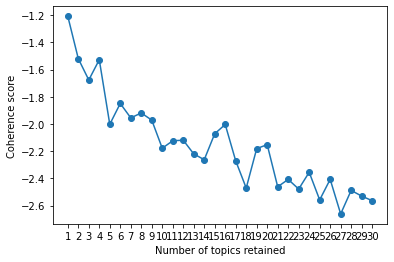

In [14]:
# set the random seed to make the results reproducible
np.random.seed(0)

# 我們相信這些文檔足夠乾淨，可以訓練主題建模。
# 使用 Tomotopy，有必要將預處理的文檔包裝在語料庫類對像中，
# 該對象必須被初始化（步驟 1）和填充（步驟 2）。
corpus = tp.utils.Corpus()                   # step 1 
for item in docs_phrased:                    # step 2 這邊輸入我們的文檔
    corpus.add_doc(words=item)

# 題建模過程的一個組成部分是探索替代模型的擬合，即保留不同數量主題的模型。
# 在此示例中，模型根據“u_ma​​ss”版本根據 Coherence Score 指標進行評估（分數越低，模型擬合越好）。
# 在第 1 步中，我們創建一個空字典來存儲不同模型的分數。
# 在第 2 步中，我們讓保留主題的數量在模型之間發生變化，並且對於每個模型，我們記錄相關的 Coherence Score
cvs = {}                                    # step 1
for topic_number in range(1, 31, 1):        # step 2
    mdl = tp.LDAModel(k=topic_number, corpus=corpus) # 這邊輸入我們的文檔
    for i in range(0, 100, 10): # 100 次迭代
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # 分數越低，模型擬合越好

# coherence of the results how to fix???????

# 這邊把csv視覺話 找最低分的
# The below chart displays the fit of the fifteen competing models, 
# retaining between one and fifteen topics.
# 下面的圖表顯示了 15 個競爭模型的擬合，保留 1 到 15 個主題。
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 31, 1))
plt.show()

# 圖表的可視檢查表示最佳模型是有 13 個主題的模型。
# 然而，為了提供更好的選擇，應該考慮更多的模型（例如在 1 到 200 主題的模型）。

In [15]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=23, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt #.head(1).T

word   prob   k  sort
0       film  0.077   0     0
1      films  0.021   0     1
2      style  0.007   0     2
3        art  0.007   0     3
4       work  0.007   0     4
..       ...    ...  ..   ...
5   original  0.009  22     5
6       year  0.009  22     6
7     disney  0.008  22     7
8      films  0.008  22     8
9   american  0.008  22     9

[230 rows x 4 columns]

In [16]:
# The second outcome of topic modeling we retrieve consists of the topic-to-document probabilities,
#  which we retrieve using the ‘get_topic_dist’ attribute, 
# available for any document included in the LDA corpus used for the training.
# 第二個主題建模的結果是主題到文件概率的預測，
# 這可以使用“get_topic_dist”屬性，可用於訓練 LDA 的資料庫中包含的任何文件。
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0      0.007364  0.005117  0.018744  0.003597  0.003844  0.001493  0.006061   
1      0.130544  0.001942  0.025363  0.031782  0.050125  0.213482  0.002300   
2      0.053294  0.011656  0.006183  0.008195  0.008757  0.003402  0.013809   
3      0.222741  0.004072  0.014918  0.002863  0.028574  0.001189  0.004824   
4      0.100386  0.005869  0.076664  0.022514  0.004409  0.020101  0.006953   
...         ...       ...       ...       ...       ...       ...       ...   
10750  0.024169  0.038407  0.002804  0.003716  0.003971  0.001543  0.055944   
10751  0.016777  0.048173  0.006183  0.008195  0.008757  0.003402  0.013809   
10752  0.020525  0.014260  0.007564  0.010025  0.010713  0.004162  0.061567   
10753  0.062411  0.013650  0.007241  0.009596  0.010254  0.003984  0.016171   
10754  0.053294  0.011656  0.006183  0.008195  0.008757  0.003402  0.013809   

        topic_8   topic_9  topic_10  ...  topic_14  topic_15  topic_16  \
0      0.003296  0.196414  0.023038  ...  0.008190  0.021046  0.017714   
1      0.007334  0.050206  0.112159  ...  0.021358  0.056653  0.073639   
2      0.007508  0.082279  0.052483  ...  0.018658  0.011427  0.113389   
3      0.002623  0.105291  0.018335  ...  0.057549  0.003992  0.014098   
4      0.003780  0.004655  0.063202  ...  0.211659  0.024141  0.093870   
...         ...       ...       ...  ...       ...       ...       ...   
10750  0.003405  0.004192  0.007240  ...  0.008462  0.170788  0.217028   
10751  0.007508  0.009244  0.015965  ...  0.018658  0.011427  0.040354   
10752  0.009185  0.011309  0.019531  ...  0.022826  0.013979  0.049368   
10753  0.051556  0.053589  0.061460  ...  0.021850  0.013381  0.090020   
10754  0.007508  0.082279  0.015965  ...  0.018658  0.011427  0.076871   

       topic_17  topic_18  topic_19  topic_20  topic_21  topic_22  topic_23  
0      0.101846  0.007420  0.004378  0.019827  0.042881  0.172260  0.101765  
1      0.032567  0.045399  0.001661  0.007525  0.022357  0.041040  0.008203  
2      0.012911  0.016904  0.009972  0.154721  0.024652  0.063771  0.012727  
3      0.030026  0.031421  0.092788  0.003023  0.021370  0.137098  0.004446  
4      0.006501  0.045287  0.023409  0.004356  0.104352  0.013723  0.006409  
...         ...       ...       ...       ...       ...       ...       ...  
10750  0.005855  0.007666  0.070765  0.020484  0.160225  0.111723  0.005772  
10751  0.012911  0.016904  0.229076  0.008652  0.097687  0.027254  0.012727  
10752  0.015795  0.065354  0.012200  0.010584  0.030159  0.122690  0.015570  
10753  0.057884  0.019795  0.011678  0.010132  0.071633  0.031916  0.014904  
10754  0.122463  0.016904  0.046490  0.008652  0.024652  0.027254  0.049244  

[10755 rows x 23 columns]

In [17]:
# from rich.console import Console
# from rich.table import Table
# # 主題模型輸出的一個關鍵部分是將單詞與隱藏主題聯繫起來的圖。
# # 在下一個代碼塊中，我們執行以下任務： 創建豐富的表（步驟 1） 
# # 使用 lda.get_topic_words 檢索主題詞概率（步驟 2） 
# # 表格顯示（步驟 3）

# console = Console()                    # step 1
# table = Table(
#     show_header=True,
#     header_style="cyan",
#     title="[bold] [cyan] Word to topic probabilities (top 10 words)[/cyan]",
#     width=150,
# )
# table.add_column("Topic", justify="center", style="cyan", width=10)
# table.add_column("t1", width=12)
# table.add_column("t2", width=12)
# table.add_column("t3", width=12)
# table.add_column("t4", width=12)
# table.add_column("t5", width=12)
# table.add_column("t6", width=12)
# table.add_column("t7", width=12)
# table.add_column("t8", width=12)
# table.add_column("t9", width=12)
# for k in range(best_mdl.k):                       # step 2 
#     values = []
#     for word, prob in best_mdl.get_topic_words(k):
#         values.append("{}\n({})\n".format(word, str(np.round(prob, 3))))       
#     table.add_row(
#         str(k),
#         values[0],
#         values[1],
#         values[2],
#         values[3],
#         values[4],
#         values[5],
#         values[6],
#         values[7],
#         values[8],
#         values[9],
#     )
# table

In [18]:
# add td to the df_train_clean
df_train_clean = pd.concat([df_train_clean, td], axis=1)
df_train_clean

imbd_user_review  \
0      it is hard to find such delightful and adorabl...   
1      they dont make films like this faded haunting ...   
2      i first viewed this movie in 1924 at age 6 yrs...   
3      i doubt that id ever seen anything resembling ...   
4      i was shocked to find myself riveted to this m...   
...                                                  ...   
10750  the makers of this movie really touched a sore...   
10751  i care a lot is an exhilarating black comedy w...   
10752  really loved this this film is masterful in th...   
10753  the story direction and acting across the boar...   
10754  this movie ruled it had such a unique premise ...   

                                                  tokens  \
0      [hard, delightful, adorable, days, kid, silent...   
1      [films, faded, haunting, masterpiece, silent, ...   
2      [viewed, age, yrsprobably, thought, terrific, ...   
3      [doubt, d, resembling, complete, version, metr...   
4      [shocked, riveted, doubt, scifi, ve, let, expl...   
...                                                  ...   
10750  [makers, touched, sore, spot, grumpy, mans, mi...   
10751  [care, lot, exhilarating, black, comedy, headt...   
10752  [loved, masterful, feel, characters, message, ...   
10753  [direction, acting, board, superb, peter, dink...   
10754  [ruled, unique, premise, acting, awesome, rose...   

                                                    tags  helpfulness_cat  \
0      ['ADJ', 'ADJ', 'ADJ', 'NOUN', 'NOUN', 'NOUN', ...              1.0   
1      ['PART', 'NOUN', 'VERB', 'VERB', 'NOUN', 'ADJ'...              1.0   
2      ['VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'VERB...              1.0   
3      ['VERB', 'AUX', 'VERB', 'ADJ', 'NOUN', 'NOUN',...              1.0   
4      ['ADJ', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN'...              1.0   
...                                                  ...              ...   
10750  ['NOUN', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'ADJ',...              0.0   
10751  ['VERB', 'NOUN', 'ADJ', 'ADJ', 'NOUN', 'NOUN',...              0.0   
10752  ['VERB', 'NOUN', 'ADJ', 'VERB', 'NOUN', 'NOUN'...              0.0   
10753  ['NOUN', 'NOUN', 'VERB', 'NOUN', 'ADJ', 'PROPN...              0.0   
10754  ['NOUN', 'VERB', 'ADJ', 'NOUN', 'NOUN', 'ADJ',...              0.0   

        topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  ...  \
0      0.007364  0.005117  0.018744  0.003597  0.003844  0.001493  ...   
1      0.130544  0.001942  0.025363  0.031782  0.050125  0.213482  ...   
2      0.053294  0.011656  0.006183  0.008195  0.008757  0.003402  ...   
3      0.222741  0.004072  0.014918  0.002863  0.028574  0.001189  ...   
4      0.100386  0.005869  0.076664  0.022514  0.004409  0.020101  ...   
...         ...       ...       ...       ...       ...       ...  ...   
10750  0.024169  0.038407  0.002804  0.003716  0.003971  0.001543  ...   
10751  0.016777  0.048173  0.006183  0.008195  0.008757  0.003402  ...   
10752  0.020525  0.014260  0.007564  0.010025  0.010713  0.004162  ...   
10753  0.062411  0.013650  0.007241  0.009596  0.010254  0.003984  ...   
10754  0.053294  0.011656  0.006183  0.008195  0.008757  0.003402  ...   

       topic_14  topic_15  topic_16  topic_17  topic_18  topic_19  topic_20  \
0      0.008190  0.021046  0.017714  0.101846  0.007420  0.004378  0.019827   
1      0.021358  0.056653  0.073639  0.032567  0.045399  0.001661  0.007525   
2      0.018658  0.011427  0.113389  0.012911  0.016904  0.009972  0.154721   
3      0.057549  0.003992  0.014098  0.030026  0.031421  0.092788  0.003023   
4      0.211659  0.024141  0.093870  0.006501  0.045287  0.023409  0.004356   
...         ...       ...       ...       ...       ...       ...       ...   
10750  0.008462  0.170788  0.217028  0.005855  0.007666  0.070765  0.020484   
10751  0.018658  0.011427  0.040354  0.012911  0.016904  0.229076  0.008652   
10752  0.022826  0.013979  0.049368  0.015795  0.065354  0.012200  0.0105

<AxesSubplot:>

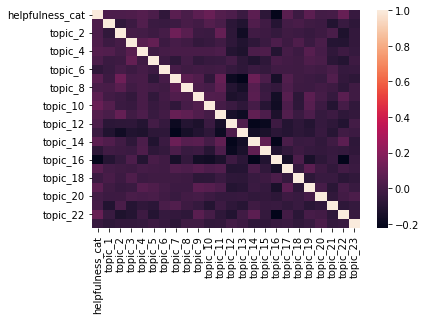

In [19]:
# draw the correlation matrix
corr = df_train_clean.corr()
sns.heatmap(corr)

### BoW
詞袋模型是一個基於單詞出現頻率來表示文字的方法，它並不考慮單詞的排列順序、或甚至是文法結構。

詞袋模型（bag-of-words language model, BoW）在今日的語言模型當中當屬最簡單、最容易理解的了。雖說如此，其應用卻十分廣泛，它可被用來找尋新聞標題、過濾詐騙郵件、找出推文的正負向情緒、甚至到建立文字雲（ word cloud ）等等。

In [20]:
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
cores = multiprocessing.cpu_count()

In [21]:
# # 這邊可以用更好的方法 平均分佈o跟1
# train_df, valid_df = train_test_split(df_train_clean, test_size=0.3, random_state=42)
df_train_clean

imbd_user_review  \
0      it is hard to find such delightful and adorabl...   
1      they dont make films like this faded haunting ...   
2      i first viewed this movie in 1924 at age 6 yrs...   
3      i doubt that id ever seen anything resembling ...   
4      i was shocked to find myself riveted to this m...   
...                                                  ...   
10750  the makers of this movie really touched a sore...   
10751  i care a lot is an exhilarating black comedy w...   
10752  really loved this this film is masterful in th...   
10753  the story direction and acting across the boar...   
10754  this movie ruled it had such a unique premise ...   

                                                  tokens  \
0      [hard, delightful, adorable, days, kid, silent...   
1      [films, faded, haunting, masterpiece, silent, ...   
2      [viewed, age, yrsprobably, thought, terrific, ...   
3      [doubt, d, resembling, complete, version, metr...   
4      [shocked, riveted, doubt, scifi, ve, let, expl...   
...                                                  ...   
10750  [makers, touched, sore, spot, grumpy, mans, mi...   
10751  [care, lot, exhilarating, black, comedy, headt...   
10752  [loved, masterful, feel, characters, message, ...   
10753  [direction, acting, board, superb, peter, dink...   
10754  [ruled, unique, premise, acting, awesome, rose...   

                                                    tags  helpfulness_cat  \
0      ['ADJ', 'ADJ', 'ADJ', 'NOUN', 'NOUN', 'NOUN', ...              1.0   
1      ['PART', 'NOUN', 'VERB', 'VERB', 'NOUN', 'ADJ'...              1.0   
2      ['VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'VERB...              1.0   
3      ['VERB', 'AUX', 'VERB', 'ADJ', 'NOUN', 'NOUN',...              1.0   
4      ['ADJ', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN'...              1.0   
...                                                  ...              ...   
10750  ['NOUN', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'ADJ',...              0.0   
10751  ['VERB', 'NOUN', 'ADJ', 'ADJ', 'NOUN', 'NOUN',...              0.0   
10752  ['VERB', 'NOUN', 'ADJ', 'VERB', 'NOUN', 'NOUN'...              0.0   
10753  ['NOUN', 'NOUN', 'VERB', 'NOUN', 'ADJ', 'PROPN...              0.0   
10754  ['NOUN', 'VERB', 'ADJ', 'NOUN', 'NOUN', 'ADJ',...              0.0   

        topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  ...  \
0      0.007364  0.005117  0.018744  0.003597  0.003844  0.001493  ...   
1      0.130544  0.001942  0.025363  0.031782  0.050125  0.213482  ...   
2      0.053294  0.011656  0.006183  0.008195  0.008757  0.003402  ...   
3      0.222741  0.004072  0.014918  0.002863  0.028574  0.001189  ...   
4      0.100386  0.005869  0.076664  0.022514  0.004409  0.020101  ...   
...         ...       ...       ...       ...       ...       ...  ...   
10750  0.024169  0.038407  0.002804  0.003716  0.003971  0.001543  ...   
10751  0.016777  0.048173  0.006183  0.008195  0.008757  0.003402  ...   
10752  0.020525  0.014260  0.007564  0.010025  0.010713  0.004162  ...   
10753  0.062411  0.013650  0.007241  0.009596  0.010254  0.003984  ...   
10754  0.053294  0.011656  0.006183  0.008195  0.008757  0.003402  ...   

       topic_14  topic_15  topic_16  topic_17  topic_18  topic_19  topic_20  \
0      0.008190  0.021046  0.017714  0.101846  0.007420  0.004378  0.019827   
1      0.021358  0.056653  0.073639  0.032567  0.045399  0.001661  0.007525   
2      0.018658  0.011427  0.113389  0.012911  0.016904  0.009972  0.154721   
3      0.057549  0.003992  0.014098  0.030026  0.031421  0.092788  0.003023   
4      0.211659  0.024141  0.093870  0.006501  0.045287  0.023409  0.004356   
...         ...       ...       ...       ...       ...       ...       ...   
10750  0.008462  0.170788  0.217028  0.005855  0.007666  0.070765  0.020484   
10751  0.018658  0.011427  0.040354  0.012911  0.016904  0.229076  0.008652   
10752  0.022826  0.013979  0.049368  0.015795  0.065354  0.012200  0.0105

In [22]:
empty_set = set()
for i in df_train_clean['tokens'].apply(lambda x:set(x)):
    empty_set = empty_set.union(i)
token_bow = list(empty_set)

In [23]:
# change the empty_set into a dict
token_dict = {}
for i in range(len(token_bow)):
    token_dict[token_bow[i]] = i
token_dict

token_dict_key = {}
for i in range(len(token_bow)):
    token_dict_key[token_bow[i]] = 0
token_dict_key


{'storyrounding': 0,
 'mensa': 0,
 'errorsfunny': 0,
 'crib': 0,
 'snatchersessentially': 0,
 'supercomputerthe': 0,
 'richter': 0,
 'stansfield': 0,
 'travelled': 0,
 'enlivened': 0,
 'ineligible': 0,
 'overactive': 0,
 'tamper': 0,
 'lung': 0,
 'cremedelacreme': 0,
 'unleashes': 0,
 'prodixie': 0,
 'tapeworm': 0,
 'alicias': 0,
 'weathering': 0,
 'shettys': 0,
 'lampwicks': 0,
 'falk': 0,
 'calvary': 0,
 'fordbaldwin': 0,
 'timewave': 0,
 'intangible': 0,
 'whoo': 0,
 'allegories': 0,
 'superiorsthere': 0,
 'crummy': 0,
 'economides': 0,
 'butits': 0,
 'blaze': 0,
 'continuento': 0,
 'waralthough': 0,
 'isare': 0,
 'religiousminded': 0,
 'caifei': 0,
 'cups': 0,
 'outmusic': 0,
 'downcheers': 0,
 'negatively': 0,
 'yesterday': 0,
 'bestow': 0,
 'unconvincing': 0,
 'claudine': 0,
 'tropicalsarcasm': 0,
 'youngmin': 0,
 'justan': 0,
 'mizrahi': 0,
 'vintage': 0,
 'knowhow': 0,
 'miharu': 0,
 'timidity': 0,
 'derail': 0,
 'squid': 0,
 'rainmaker': 0,
 'tightened': 0,
 'attain': 0,
 'bra

In [44]:
token_dict_key = {}
for i in range(len(token_bow)):
    token_dict_key[token_bow[i]] = 0

token_dict_key_tmp = {}
for i in range(len(token_bow)):
    token_dict_key_tmp[token_bow[i]] = 0

df_train_clean['BoW'] = df_train_clean['tokens'].apply(lambda x:token_dict_key.copy())

# count the frequency of each token in df_train_clean['tokens'] and store it in df_train_clean['BoW']
for i in range(len(df_train_clean['tokens'])):
    for j in range(len(df_train_clean['tokens'][i])):
        df_train_clean['BoW'][i][df_train_clean['tokens'][i][j]] += 1

# unboxing the df_train_clean['BoW']
tmp_df = df_train_clean['BoW'].apply(lambda x:list(x.values()))
# make the test_df as a dataframe

df_train_clean['BoW'] = pd.DataFrame(tmp_df)

# check inside the df_train_clean['BoW'][0] there is not 0
for i in range(len(df_train_clean['BoW'][0])):
    if df_train_clean['BoW'][0][i] != 0:
        print("not 0")

In [76]:
# df_train_clean['BoW']

# change the td to a list of lists
tmp_df = df_train_clean['BoW'].apply(lambda x:list(x))
tmp_df
# # make the test_df as a dataframe
# df_train_clean['BoW'] = pd.DataFrame(tmp_df)    



0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
10750    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10751    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10752    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10753    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10754    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: BoW, Length: 10755, dtype: object

In [59]:
# # We get an iterable with the tokenized documents as follows:
# # voc = sorted(set(sum(docs_tokens, [])))

# from typing import Dict, List, Tuple
# import collections

# def doc2bow(tkns_, voc_: Dict[str, int]) -> List[Tuple[int, int]]:
#     tkns_count = collections.defaultdict(int)     # step 1
#     for tkn in tkns_:
#         if tkn not in voc_:                       # step 2
#             voc_[tkn] = len(voc_)                 # step 3
#         tkns_count[voc_[tkn]] += 1.               # step 4

#     return list(tkns_count.items())

# def doc2bow(tkns_, voc_: Dict[str, int]) -> List[Tuple[int, int]]:
#     tkns_count = collections.defaultdict(int)     # step 1
#     for tkn in tkns_:
#         if tkn not in voc_:                       # step 2
#             voc_[tkn] = len(voc_)                 # step 3
#         tkns_count[voc_[tkn]] += 1               # step 4

#     return list(tkns_count.items())

# from nltk.tokenize import TreebankWordTokenizer
# voc = {}
# tkns_= doc2bow(TreebankWordTokenizer().tokenize(df_train_clean['imbd_user_review'][0]), voc_=voc)

# tkns_

### Logistic Regression

In [85]:
# train test split with the df_train_clean
train_df, valid_df = train_test_split(df_train_clean, test_size=0.3, random_state=42)
# x_train_df, x_valid_df = train_test_split(tmp_df, test_size=0.3, random_state=42)
print(len(train_df))
print(len(valid_df))

7528
3227


In [86]:
y_train_df = train_df[['helpfulness_cat']]
y_valid_df = valid_df[['helpfulness_cat']]
x_train_df = train_df.drop(['helpfulness_cat', 'tokens', 'imbd_user_review', 'tags', 'BoW'], axis=1)
x_valid_df = valid_df.drop(['helpfulness_cat', 'tokens', 'imbd_user_review', 'tags', 'BoW'], axis=1)

In [87]:
def simple_logistic_classify(x_train_df, y_train_df, x_valid_df, y_valid_df, _C=1):
    model = LogisticRegression(C=_C).fit(x_train_df, y_train_df)
    score = model.score(x_valid_df, y_valid_df)
    print('Test Score is', score)
    return model

In [88]:
model = simple_logistic_classify(x_train_df, y_train_df, x_valid_df, y_valid_df)

Test Score is 0.7716145026340254


/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
# hype-parameter tuning 
from sklearn.model_selection import GridSearchCV
import sklearn
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
# bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)

In [91]:
# confusion matrix and classification report(precision, recall, F1-score)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_valid_df, model.predict(x_valid_df)))
print(confusion_matrix(y_valid_df, model.predict(x_valid_df)))

              precision    recall  f1-score   support

         0.0       0.52      0.06      0.11       740
         1.0       0.78      0.98      0.87      2487

    accuracy                           0.77      3227
   macro avg       0.65      0.52      0.49      3227
weighted avg       0.72      0.77      0.70      3227

[[  46  694]
 [  43 2444]]


https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205



### Try model

In [9]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from collections import namedtuple

from bs4 import BeautifulSoup

import re                                  # library for regular expression operations
import string                              # for string operations

import nltk 
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
df_train

In [11]:
train, valid = train_test_split(df_train, test_size=0.3, random_state=42)

In [12]:
train

helpfulness_cat                                   imdb_user_review
10303              1.0  When I see reviews like this I get really susp...
2175               1.0  There aren't many Tennis movies so when one do...
5682               0.0  This movie makes you cry and smile. It shows t...
2540               0.0  Though in a Medieval setting, the two main cha...
7281               1.0  As far as I know this is the first time the il...
...                ...                                                ...
5734               1.0  There is one thing you have to know before eve...
5191               1.0  What a bitter disappointment! In order to expl...
5390               1.0  Usually I write positive reviews but for this ...
860                1.0  I first watched this film in Japanese with a 1...
7270               1.0  I enjoyed this movie very much. I laughed and ...

[7528 rows x 2 columns]

In [13]:
valid

helpfulness_cat                                   imdb_user_review
9043               1.0  I got quite excited at the beginning when the ...
1501               0.0  Hard to believe that so many people seem to be...
6044               1.0  If you like those 3 or 5 minute GoPro or Red B...
10720              1.0  Totally sappy, cheesy, silly, but sometimes yo...
10196              1.0  Whip-smart 1-2-3 dialogue and film-editing, te...
...                ...                                                ...
6399               1.0  Don't expect a masterpiece just a very enjoyab...
5936               1.0  The Actors were magnificent, fit their charact...
4770               0.0  As I've said before, you need to have a great ...
564                1.0  A gang called the 'Warriors,' exhibits qualiti...
1582               1.0  The Thirteenth Floor is a thoughtful and engag...

[3227 rows x 2 columns]

### Preprocessing text

In [15]:
# clean text
def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    #text = text.str
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'#', '', text)
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    text_clean = []
    for word in text_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation): 
            stem_word = stemmer.stem(word)  # stemming word
            text_clean.append(stem_word)
            
    return text_clean
    #text_clean_2 = ' '.join(text_clean)

    #return text_clean_2

In [16]:
# For Doc2Vec: If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
# Building TaggedDocument # 這邊把詞彙轉換成同一個token跟代號
def Tagged_Document(df):
  doc_tagged = df.apply(lambda r: TaggedDocument(words=process_text(r['imdb_user_review']), tags=[r['helpfulness_cat']]), axis=1)
  return doc_tagged

# Building the Final Vector Feature for the Classifier
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents]) # , steps=20c
    return targets, regressors




In [17]:
# -------- TaggedDocument
train_tagged = Tagged_Document(train)
valid_tagged = Tagged_Document(valid)

In [18]:
train_tagged

10303    ([see, review, like, get, realli, suspici, leg...
2175     ([mani, tenni, movi, one, come, tenni, fan, qu...
5682     ([movi, make, cri, smile, show, hell, war, alw...
2540     ([though, mediev, set, two, main, charact, tal...
7281     ([far, know, first, time, illustri, studio, gh...
                               ...                        
5734     ([one, thing, know, even, read, movi, summari,...
5191     ([bitter, disappoint, order, explain, miss, fi...
5390     ([usual, write, posit, review, movi, specif, w...
860      ([first, watch, film, japanes, 12, year, old, ...
7270     ([enjoy, movi, much, laugh, cri, time, stori, ...
Length: 7528, dtype: object

In [26]:
len(train_tagged[10303][0])
len(train_tagged[2175][0])

70

In [19]:
len(train_tagged[10303][0])

96

In [20]:
# #### log without pipeline
# logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter = 1000)

In [21]:
# #### pipeline
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# pipe = make_pipeline(StandardScaler(), LogisticRegression(n_jobs=1, C=1e5, max_iter = 1000))

In [22]:
# pipe

### bow, tagged, log

In [23]:
# first model
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 7528/7528 [00:00<00:00, 2237279.14it/s]


In [24]:
# Training a doc2vec model is rather straight-forward in Gensim, 
# we initialize the model and train for 30 epochs.
# %%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), 
                     total_examples=len(train_tagged.values), 
                     epochs=1)
    model_dbow.alpha -= 0.002 # learning rate parameter
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 7528/7528 [00:00<00:00, 3970664.05it/s]


In [25]:
train_tagged

10303    ([see, review, like, get, realli, suspici, leg...
2175     ([mani, tenni, movi, one, come, tenni, fan, qu...
5682     ([movi, make, cri, smile, show, hell, war, alw...
2540     ([though, mediev, set, two, main, charact, tal...
7281     ([far, know, first, time, illustri, studio, gh...
                               ...                        
5734     ([one, thing, know, even, read, movi, summari,...
5191     ([bitter, disappoint, order, explain, miss, fi...
5390     ([usual, write, posit, review, movi, specif, w...
860      ([first, watch, film, japanes, 12, year, old, ...
7270     ([enjoy, movi, much, laugh, cri, time, stori, ...
Length: 7528, dtype: object

In [26]:
y_train_dbow, X_train_dbow = vec_for_learning(model_dbow, train_tagged)
y_valid_dbow, X_valid_dbow = vec_for_learning(model_dbow, valid_tagged)

In [27]:
y_train_dbow = np.array(y_train_dbow)
X_train_dbow = np.array(X_train_dbow)
y_valid_dbow = np.array(y_valid_dbow)
X_valid_dbow = np.array(X_valid_dbow)

In [28]:
len(X_train_dbow)
X_train_dbow.shape

(7528, 300)

In [29]:
len(y_train_dbow)
y_train_dbow.shape

(7528,)

In [30]:
y_train_dbow

array([1., 1., 0., ..., 1., 1., 1.])

In [31]:
X_train_dbow

array([[ 0.635625  ,  0.3911948 ,  0.9367416 , ...,  0.16619784,
        -0.5801694 ,  0.38351798],
       [ 0.51653475,  0.32893777,  0.76783705, ...,  0.13042964,
        -0.47994652,  0.31983712],
       [ 0.41095042,  0.24757954,  0.60110784, ...,  0.11524644,
        -0.3906786 ,  0.25584203],
       ...,
       [ 0.6107675 ,  0.38100594,  0.90338135, ...,  0.15340132,
        -0.56181955,  0.37409788],
       [ 0.50463784,  0.31244645,  0.74751717, ...,  0.12372374,
        -0.46651244,  0.31220007],
       [ 0.44013646,  0.25527135,  0.6384526 , ...,  0.12704758,
        -0.4190305 ,  0.272513  ]], dtype=float32)

### using tensorflow of LSTM model to build model

In [32]:
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset

from sklearn.model_selection import train_test_split
import keras

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D
from tensorflow.keras import backend as K
from scipy.ndimage import zoom

# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)


In [33]:
X_train_dbow.shape

(7528, 300)

In [34]:
y_train_dbow

array([1., 1., 0., ..., 1., 1., 1.])

In [35]:
model_LSTM = Sequential([
    LSTM(300, return_sequences=True,),
    #BatchNormalization(), # We tried it and it didn't make much difference
    LSTM(20),
    Dense(2, activation="softmax")
])

learning_rate = 0.001
model_LSTM.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])

# model_LSTM.summary()

2022-06-27 15:15:30.512482: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
# fit the model 
history = model_LSTM.fit(X_train_dbow, y_train_dbow, epochs=10, validation_data=(X_valid_dbow, y_valid_dbow))

Epoch 1/10


ValueError: in user code:

    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 300)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 300), dtype=float32)
      • training=True
      • mask=None


In [ ]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_LSTM= model_LSTM.fit(X_train_dbow, y_train_dbow, 
                epochs=epochs,
                validation_data=(X_valid_dbow, y_valid_dbow),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20


ValueError: in user code:

    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/py38_tsf_env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 7528, 300), found shape=(None, 300)


In [ ]:
# fit
logreg.fit(X_train_dbow, y_train_dbow)

# predict
y_pred_dbow = logreg.predict(X_test_dbow)
print(confusion_matrix(y_pred_dbow,y_test_dbow))
print(classification_report(y_pred_dbow,y_test_dbow))